# Build models for prediction

## This notebook very similar to previous but creates a proxy variable deltaTsec which is number of seconds since the first data item.  This captures all the information inor month, week, day (and time and year).    Because it is based on datetime it can be used with the validation data for prediction

### Uses new data files from 20210608


#### Here 



* Template_905.xlsx          
* validation905.xlsx
* training905.xlsx



In a *regression* problem, we try to predict the output of a continuous value, like a price or a probability. 

This notebook uses the `tf.keras` API, see [this guide](https://www.tensorflow.org/guide/keras) for details.

In [1]:
# Use seaborn for pairplot
!pip install -q seaborn

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
pip install pandas

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.0


Prep GPU

In [5]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## The training dataset

File: PO4_Training.xlsx

In [7]:
pip install openpyxl

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [8]:
bb

Take a look.

In [9]:
data.head()

,datetime,Year,Time,Month,Day,Week,GHI,TEMP,PH,EC,TURB,SA DO,SA NO3,SA NH4,SA PO4
0,2016-01-01 00:00:00,2016,00:00:00,1,1,1,2.350,10.000,7.870,1882.000,27.000,8.900,21.300,0.810,0.310
1,2016-01-01 00:00:00,2016,00:00:00,1,1,1,2.350,9.759,7.842,1901.641,26.753,9.174,21.555,0.799,0.289
2,2016-01-01 00:00:00,2016,00:00:00,1,1,1,2.350,9.816,7.858,1923.555,26.720,9.551,21.220,0.595,0.275
3,2016-01-01 00:00:00,2016,00:00:00,1,1,1,2.350,9.806,7.856,1837.397,26.445,8.348,21.830,0.916,0.362
4,2016-01-01 00:15:00,2016,00:15:00,1,1,1,2.337,10.000,7.860,1885.000,27.000,9.000,21.300,0.810,0.310


In [10]:
data.tail()

,datetime,Year,Time,Month,Day,Week,GHI,TEMP,PH,EC,TURB,SA DO,SA NO3,SA NH4,SA PO4
433327,2020-12-31 23:30:00,2020,23:30:00,12,31,5,1.815,7.747,8.394,699.830,NaN,12.233,13.181,-0.072,0.123
433328,2020-12-31 23:45:00,2020,23:45:00,12,31,5,1.733,7.600,8.340,715.000,NaN,12.200,13.400,0.160,0.180
433329,2020-12-31 23:45:00,2020,23:45:00,12,31,5,1.733,7.701,8.338,695.460,NaN,11.723,13.465,0.108,0.205
433330,2020-12-31 23:45:00,2020,23:45:00,12,31,5,1.733,8.070,8.304,681.666,NaN,12.485,12.408,-0.058,0.244
433331,2020-12-31 23:45:00,2020,23:45:00,12,31,5,1.733,7.495,8.356,756.958,NaN,11.342,13.893,0.065,0.165


In [11]:
data.columns

Index(['datetime', 'Year', 'Time', 'Month', 'Day', 'Week', 'GHI', 'TEMP', 'PH',
       'EC', 'TURB', 'SA DO', 'SA NO3', 'SA NH4', 'SA PO4'],
      dtype='object')

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433332 entries, 0 to 433331
Data columns (total 15 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   datetime  433332 non-null  datetime64[ns]
 1   Year      433332 non-null  int64         
 2   Time      433332 non-null  object        
 3   Month     433332 non-null  int64         
 4   Day       433332 non-null  int64         
 5   Week      433332 non-null  int64         
 6   GHI       433332 non-null  float64       
 7   TEMP      433332 non-null  float64       
 8   PH        433332 non-null  float64       
 9   EC        433332 non-null  float64       
 10  TURB      409652 non-null  float64       
 11  SA DO     433332 non-null  float64       
 12  SA NO3    433332 non-null  float64       
 13  SA NH4    433332 non-null  float64       
 14  SA PO4    433332 non-null  float64       
dtypes: datetime64[ns](1), float64(9), int64(4), object(1)
memory usage: 49.6+ MB


### Clean the data

How many NaNs??

In [13]:
data.isna().sum()

datetime        0
Year            0
Time            0
Month           0
Day             0
Week            0
GHI             0
TEMP            0
PH              0
EC              0
TURB        23680
SA DO           0
SA NO3          0
SA NH4          0
SA PO4          0
dtype: int64

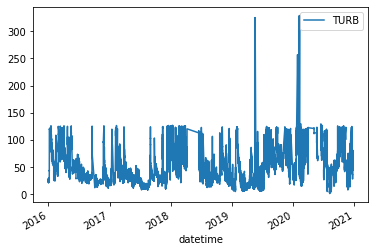

In [14]:
data.plot(x='datetime', y="TURB");

For now, we impute the mean for any missing values.

In [15]:
data = data.fillna(data.mean())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


In [16]:
data.isna().sum()

datetime    0
Year        0
Time        0
Month       0
Day         0
Week        0
GHI         0
TEMP        0
PH          0
EC          0
TURB        0
SA DO       0
SA NO3      0
SA NH4      0
SA PO4      0
dtype: int64

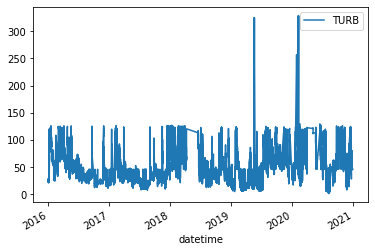

In [17]:
data.plot(x='datetime', y="TURB");

In [18]:
data.tail()

,datetime,Year,Time,Month,Day,Week,GHI,TEMP,PH,EC,TURB,SA DO,SA NO3,SA NH4,SA PO4
433327,2020-12-31 23:30:00,2020,23:30:00,12,31,5,1.815,7.747,8.394,699.830,45.961843,12.233,13.181,-0.072,0.123
433328,2020-12-31 23:45:00,2020,23:45:00,12,31,5,1.733,7.600,8.340,715.000,45.961843,12.200,13.400,0.160,0.180
433329,2020-12-31 23:45:00,2020,23:45:00,12,31,5,1.733,7.701,8.338,695.460,45.961843,11.723,13.465,0.108,0.205
433330,2020-12-31 23:45:00,2020,23:45:00,12,31,5,1.733,8.070,8.304,681.666,45.961843,12.485,12.408,-0.058,0.244
433331,2020-12-31 23:45:00,2020,23:45:00,12,31,5,1.733,7.495,8.356,756.958,45.961843,11.342,13.893,0.065,0.165



---

### Figure out how to turn datetime into time delta from 2016-01-01 00:00:00


In [19]:
times = data.datetime

In [20]:
times[:5]

0   2016-01-01 00:00:00
1   2016-01-01 00:00:00
2   2016-01-01 00:00:00
3   2016-01-01 00:00:00
4   2016-01-01 00:15:00
Name: datetime, dtype: datetime64[ns]

In [21]:
time0 = times[0]

In [22]:
type(times[1] - times[0])

pandas._libs.tslibs.timedeltas.Timedelta

In [23]:
delta1 = times[4] - times[0]; delta1

Timedelta('0 days 00:15:00')

In [24]:
delta1.seconds

900

In [25]:
type(delta1.seconds)

int

In [26]:
deltaT = times - time0

In [37]:
deltaTsec = deltaT.apply(lambda x: x.total_seconds())

In [38]:
deltaTsec[-25:]

433307    157846500.0
433308    157847400.0
433309    157847400.0
433310    157847400.0
433311    157847400.0
433312    157848300.0
433313    157848300.0
433314    157848300.0
433315    157848300.0
433316    157849200.0
433317    157849200.0
433318    157849200.0
433319    157849200.0
433320    157850100.0
433321    157850100.0
433322    157850100.0
433323    157850100.0
433324    157851000.0
433325    157851000.0
433326    157851000.0
433327    157851000.0
433328    157851900.0
433329    157851900.0
433330    157851900.0
433331    157851900.0
Name: datetime, dtype: float64

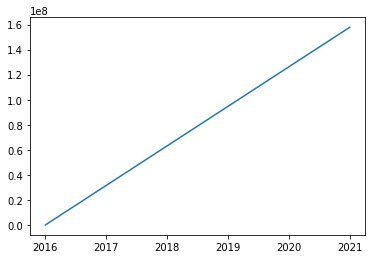

In [40]:
plt.plot(data['datetime'], deltaTsec)

In [41]:
data['deltaTsec'] = deltaTsec

In [42]:
data.head()

,datetime,Year,Time,Month,Day,Week,GHI,TEMP,PH,EC,TURB,SA DO,SA NO3,SA NH4,SA PO4,deltaTsec
0,2016-01-01 00:00:00,2016,00:00:00,1,1,1,2.350,10.000,7.870,1882.000,27.000,8.900,21.300,0.810,0.310,0.0
1,2016-01-01 00:00:00,2016,00:00:00,1,1,1,2.350,9.759,7.842,1901.641,26.753,9.174,21.555,0.799,0.289,0.0
2,2016-01-01 00:00:00,2016,00:00:00,1,1,1,2.350,9.816,7.858,1923.555,26.720,9.551,21.220,0.595,0.275,0.0
3,2016-01-01 00:00:00,2016,00:00:00,1,1,1,2.350,9.806,7.856,1837.397,26.445,8.348,21.830,0.916,0.362,0.0
4,2016-01-01 00:15:00,2016,00:15:00,1,1,1,2.337,10.000,7.860,1885.000,27.000,9.000,21.300,0.810,0.310,900.0


---

### Split the data into train and test

Now split the dataset into a training set and a test set.  Note use of sample.  That grabs a random selection of data of the desired size.

We will use the test set in the final evaluation of our models.



In [43]:
train_data = data.sample(frac=0.9, random_state=0)
test_data = data.drop(train_data.index)

In [44]:
len(train_data)

389999

In [45]:
len(test_data)

43333

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.  One target and five features.  It's looking like there are some outliers in PH.


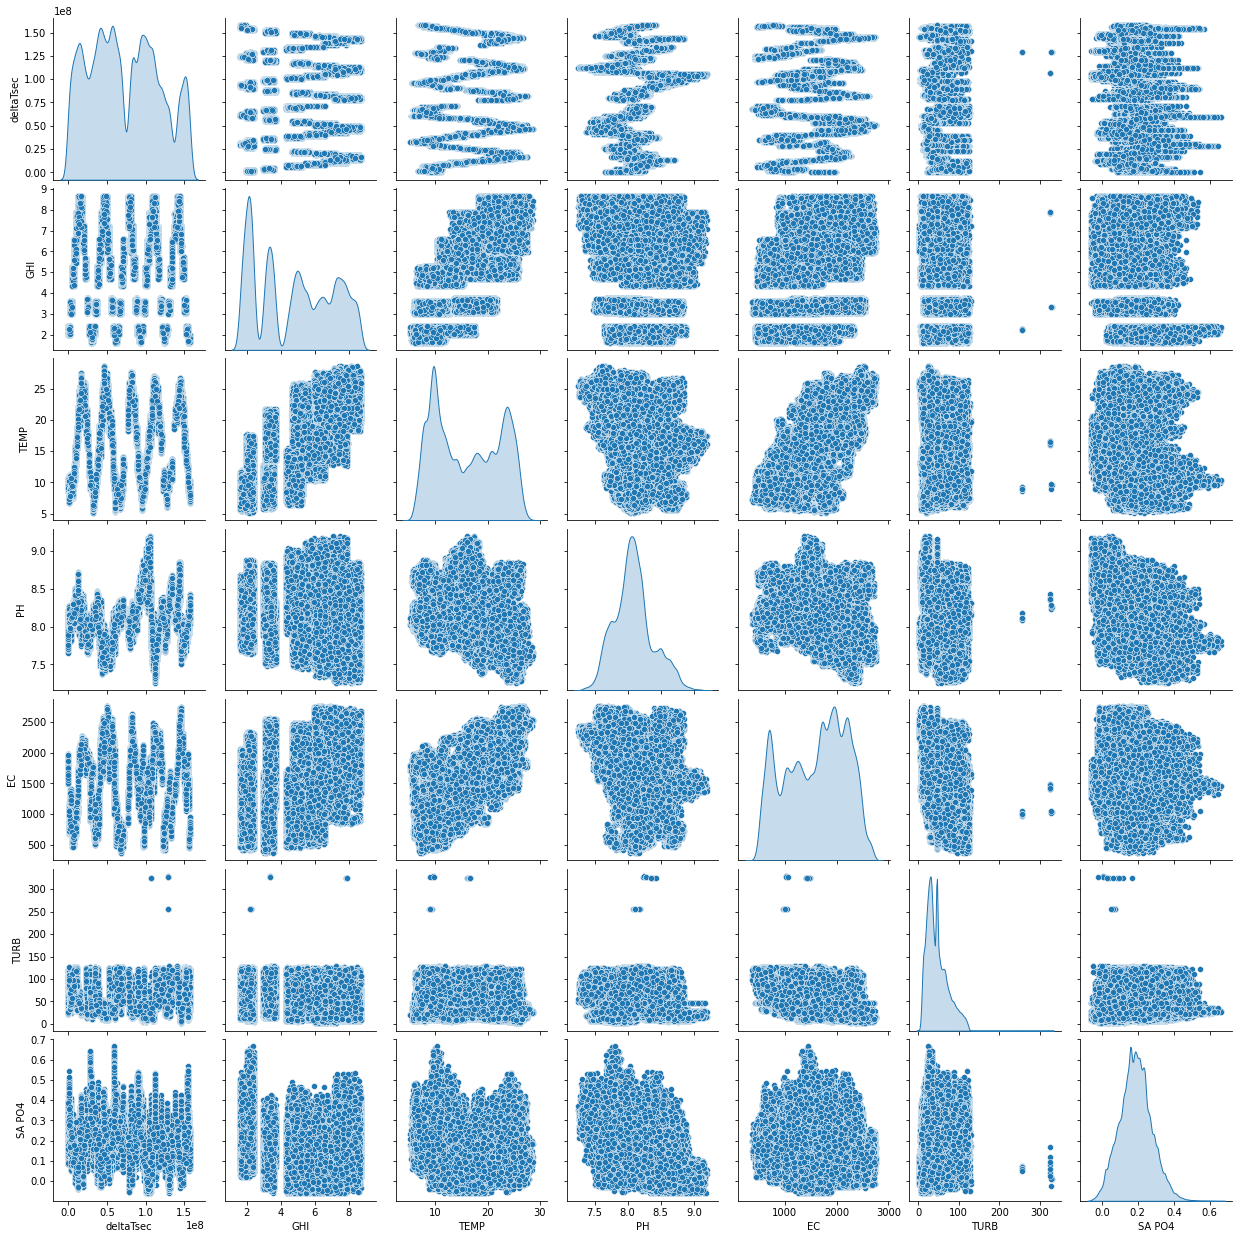

In [46]:
sns.pairplot(train_data[['deltaTsec', "GHI","TEMP","PH","EC","TURB", 'SA PO4']], diag_kind='kde')

Some interesting things show up with time variable included.

Also look at the overall statistics, note how each feature covers a very different range:

In [47]:
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Year,389999.0,2.017800e+03,1.354273e+00,2016.000,2.017000e+03,2.018000e+03,2.019000e+03,2.020000e+03
Month,389999.0,6.542648e+00,3.512460e+00,1.000,3.000000e+00,7.000000e+00,1.000000e+01,1.200000e+01
Day,389999.0,1.561748e+01,8.850489e+00,1.000,8.000000e+00,1.600000e+01,2.300000e+01,3.100000e+01
Week,389999.0,2.686563e+00,1.279137e+00,1.000,2.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00
GHI,389999.0,4.797451e+00,2.206960e+00,1.620,2.387000e+00,4.872000e+00,6.839000e+00,8.690000e+00
TEMP,389999.0,1.606720e+01,6.217601e+00,5.132,1.009900e+01,1.570000e+01,2.220000e+01,2.873300e+01
PH,389999.0,8.084271e+00,2.925270e-01,7.255,7.895000e+00,8.067000e+00,8.234000e+00,9.200000e+00
EC,389999.0,1.590915e+03,5.808899e+02,363.915,1.097687e+03,1.688593e+03,2.071064e+03,2.759993e+03
TURB,389999.0,4.599056e+01,2.565136e+01,1.306,2.679600e+01,4.054300e+01,6.095650e+01,3.287990e+02
SA DO,389999.0,7.659964e+00,2.404185e+00,0.218,5.837000e+00,7.700000e+00,9.546000e+00,1.438400e+01


### Split features from targets

Separate the target values from the features.  

As a first cut, I'm going to leave out month, day and week because of inconsistencies between the files that I downloaded from Vishy.

Also, I'll just do one target (PO4) to get on the air.

'datetime', 'Year', 'Time', 'Month', 'Day', 'Week', 'GHI', 'TEMP', 'PH',
       'EC', 'TURB', 'SA DO', 'SA NO3', 'SA NH4', 'SA PO4']

In [49]:
train_features = train_data[['deltaTsec', 'GHI', 'TEMP', 'PH', 'EC', 'TURB']]
test_features = test_data[['deltaTsec', 'GHI', 'TEMP', 'PH', 'EC', 'TURB']]

In [50]:
train_target = train_data[['SA PO4']]
test_target = test_data[['SA PO4']]

In [51]:
train_features.head()

,deltaTsec,GHI,TEMP,PH,EC,TURB
121339,40423500.0,5.459,17.320,7.894,1340.190,45.961843
288783,95913900.0,2.237,8.040,8.712,1853.642,21.243000
101841,34731900.0,3.112,9.368,8.154,1060.954,113.972000
285799,95215500.0,2.201,6.825,8.559,1820.651,22.572000
380441,130019400.0,3.629,11.660,8.271,1142.789,36.890000


In [52]:
test_features.head()

,deltaTsec,GHI,TEMP,PH,EC,TURB
21,4500.0,1.987,9.766,7.848,1907.415,27.995
27,5400.0,2.099,9.803,7.842,1849.197,26.633
43,9000.0,2.024,10.438,7.854,1892.609,28.255
46,9900.0,2.155,9.697,7.864,1851.037,27.491
92,21600.0,2.275,10.000,7.830,1899.000,27.000


In [53]:
train_target.head()

,SA PO4
121339,0.217
288783,0.115
101841,0.269
285799,0.233
380441,0.014


In [54]:
test_target.head()

,SA PO4
21,0.274
27,0.212
43,0.216
46,0.330
92,0.260


## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are.

In [55]:
train_data.describe().transpose()[['50%', 'mean', 'std' ]]

,50%,mean,std
Year,2.018000e+03,2.017800e+03,1.354273e+00
Month,7.000000e+00,6.542648e+00,3.512460e+00
Day,1.600000e+01,1.561748e+01,8.850489e+00
Week,3.000000e+00,2.686563e+00,1.279137e+00
GHI,4.872000e+00,4.797451e+00,2.206960e+00
TEMP,1.570000e+01,1.606720e+01,6.217601e+00
PH,8.067000e+00,8.084271e+00,2.925270e-01
EC,1.688593e+03,1.590915e+03,5.808899e+02
TURB,4.054300e+01,4.599056e+01,2.565136e+01
SA DO,7.700000e+00,7.659964e+00,2.404185e+00


It is good practice to normalize features that use different scales and ranges. 

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs. 

Although a model *might* converge without feature normalization, normalization makes training much more stable. 

### The Normalization layer
The `preprocessing.Normalization` layer is a clean and simple way to build that preprocessing into your model.

The first step is to create the layer:

In [56]:
normalizer = preprocessing.Normalization()

Then `.adapt()` it to the data:

In [57]:
normalizer.adapt(np.array(train_features))

This calculates the mean and variance, and stores them in the layer. 

In [58]:
print(normalizer.mean.numpy())

[72663370.           4.797       16.067        8.084     1590.915
       45.991]


When the layer is called it returns the input data, with each feature independently normalized:

In [59]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[40423500.          5.46       17.32        7.89     1340.19       45.96]]

Normalized: [[-0.73  0.3   0.2  -0.65 -0.43 -0.  ]]


## Linear regression

Before building a DNN model, start with a linear regression.

### One Variable

Start with a single-variable linear regression, to predict `PO4` from `TEMP`.

Training a model with `tf.keras` typically starts by defining the model architecture.

In this case we use a `keras.Sequential` model. This model represents a sequence of steps. In this case there are two steps:

* Normalize the input `TEMP`.
* Apply a linear transformation ($y = mx+b$) to produce 1 output using `layers.Dense`.

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

First create the temp `Normalization` layer:

In [60]:
temp = np.array(train_features['TEMP'])

temp_normalizer = preprocessing.Normalization(input_shape=[1,])
temp_normalizer.adapt(temp)

Build the sequential model:

In [61]:
temp_model = tf.keras.Sequential([
    temp_normalizer,
    layers.Dense(units=1)
])

temp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model will predict `PO4` from `TEMP`.

Run the untrained model on the first 10 temp values. The output won't be good, but you'll see that it has the expected shape, `(10,1)`:

In [62]:
temp_model.predict(temp[:10])

array([[ 0.18 ],
       [-1.156],
       [-0.965],
       [-1.331],
       [-0.635],
       [ 1.259],
       [-0.949],
       [-0.08 ],
       [-0.851],
       [-1.047]], dtype=float32)

Once the model is built, configure the training procedure using the `Model.compile()` method. The most important arguments to compile are the `loss` and the `optimizer` since these define what will be optimized (`mean_absolute_error`) and how (using the `optimizers.Adam`).

In [63]:
temp_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Once the training is configured, use `Model.fit()` to execute the training:

In [64]:
%%time
history = temp_model.fit(
    train_features['TEMP'], train_target,
    epochs=10,
    # don't suppress logging
    verbose=1,
    # Calculate validation results on 10% of the training data
    validation_split = 0.1)

Epoch 1/10
10969/10969 [==============================] - 9s 839us/step - loss: 0.0784 - val_loss: 0.0697
Epoch 2/10
10969/10969 [==============================] - 9s 823us/step - loss: 0.0748 - val_loss: 0.0855
Epoch 3/10
10969/10969 [==============================] - 9s 831us/step - loss: 0.0748 - val_loss: 0.0851
Epoch 4/10
10969/10969 [==============================] - 9s 824us/step - loss: 0.0748 - val_loss: 0.0695
Epoch 5/10
10969/10969 [==============================] - 9s 834us/step - loss: 0.0750 - val_loss: 0.0717
Epoch 6/10
10969/10969 [==============================] - 9s 817us/step - loss: 0.0750 - val_loss: 0.0843
Epoch 7/10
10969/10969 [==============================] - 9s 831us/step - loss: 0.0747 - val_loss: 0.0704
Epoch 8/10
10969/10969 [==============================] - 9s 820us/step - loss: 0.0745 - val_loss: 0.0802
Epoch 9/10
10969/10969 [==============================] - 9s 840us/step - loss: 0.0751 - val_loss: 0.0723
Epoch 10/10
10969/10969 [=====================

Visualize the model's training progress using the stats stored in the `history` object.

In [65]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
5,0.075001,0.084307,5
6,0.074761,0.070398,6
7,0.074990,0.080165,7
8,0.075022,0.072283,8
9,0.074950,0.069026,9


In [66]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  # plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [PO4]')
  plt.legend()
  plt.grid(True)

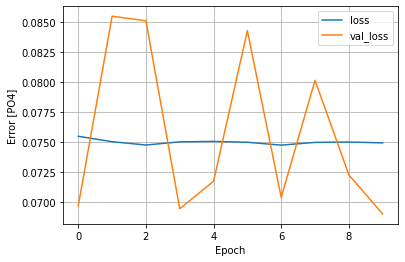

In [67]:
plot_loss(history)

Collect the results on the test set, for later:

In [68]:
test_results = {}

test_results['temp_model'] = temp_model.evaluate(
    test_features['TEMP'],
    test_target, verbose=0)

SInce this is a single variable regression it's easy to look at the model's predictions as a function of the input:

In [69]:
x = tf.linspace(5.0, 30, 251)
y = temp_model.predict(x)

In [70]:
def plot_temp(x, y):
  plt.scatter(train_features['TEMP'], train_target, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Temp')
  plt.ylabel('PO3')
  plt.legend()

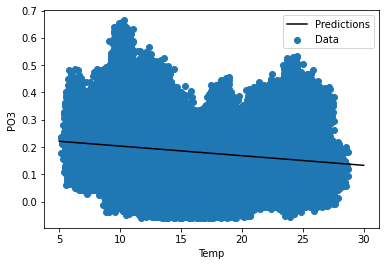

In [71]:
plot_temp(x,y)

### Multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

This time use the `Normalization` layer that was adapted to the whole dataset.

In [73]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [74]:
linear_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 6)                 13        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 20
Trainable params: 7
Non-trainable params: 13
_________________________________________________________________


When you call this model on a batch of inputs, it produces `units=1` outputs for each example.

In [75]:
linear_model.predict(train_features[:10])

array([[ 0.282],
       [ 0.553],
       [ 0.194],
       [ 0.593],
       [ 0.509],
       [-1.166],
       [ 1.221],
       [-0.275],
       [ 1.369],
       [ 1.805]], dtype=float32)

When you call the model it's weight matrices will be built. Now you can see that the `kernel` (the $m$ in $y=mx+b$) has a shape of `(6,1)`.

In [77]:
linear_model.layers[1].kernel

<tf.Variable 'dense_2/kernel:0' shape=(6, 1) dtype=float32, numpy=
array([[-0.273],
       [-0.915],
       [ 0.211],
       [-0.093],
       [-0.586],
       [-0.387]], dtype=float32)>

Use the same `compile` and `fit` calls as for the single input `TEMP` model:

In [78]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [79]:
%%time
history = linear_model.fit(
    train_features, train_target, 
    epochs=20,
    # don't suppress logging
    verbose=1,
    # Calculate validation results on 10% of the training data
    validation_split = 0.1)

Epoch 1/20
10969/10969 [==============================] - 9s 838us/step - loss: 0.0858 - val_loss: 0.0846
Epoch 2/20
10969/10969 [==============================] - 9s 846us/step - loss: 0.0827 - val_loss: 0.0794
Epoch 3/20
10969/10969 [==============================] - 9s 839us/step - loss: 0.0829 - val_loss: 0.0847
Epoch 4/20
10969/10969 [==============================] - 9s 834us/step - loss: 0.0815 - val_loss: 0.0897
Epoch 5/20
10969/10969 [==============================] - 9s 834us/step - loss: 0.0829 - val_loss: 0.0952
Epoch 6/20
10969/10969 [==============================] - 9s 839us/step - loss: 0.0819 - val_loss: 0.1014
Epoch 7/20
10969/10969 [==============================] - 9s 834us/step - loss: 0.0822 - val_loss: 0.1075
Epoch 8/20
10969/10969 [==============================] - 9s 836us/step - loss: 0.0824 - val_loss: 0.0839
Epoch 9/20
10969/10969 [==============================] - 9s 828us/step - loss: 0.0820 - val_loss: 0.1059
Epoch 10/20
10969/10969 [=====================

Using all the inputs does not improve training and validation error than the `TEMP` model: 

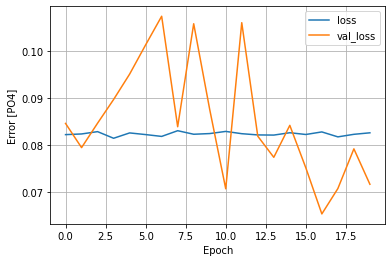

In [80]:
plot_loss(history)

Collect the results on the test set, for later:

In [81]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_target, verbose=0)

In [82]:
test_results

{'temp_model': 0.06948475539684296, 'linear_model': 0.07169545441865921}

## A DNN regression

The previous section implemented linear models for single and multiple inputs.

This section implements single-input and multiple-input DNN models. The code is basically the same except the model is expanded to include some "hidden"  non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer.
* Two hidden, nonlinear, `Dense` layers using the `relu` nonlinearity.
* A linear single-output layer.

Both will use the same training procedure so the `compile` method is included in the `build_and_compile_model` function below.

In [83]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### One variable

Start with a DNN model for a single input: "TEMP"

In [84]:
dnn_temp_model = build_and_compile_model(temp_normalizer)

This model has quite a few more trainable parameters than the linear models.

In [85]:
dnn_temp_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


Train the model:

In [86]:
%%time
history = dnn_temp_model.fit(
    train_features['TEMP'], train_target,
    validation_split=0.1,
    verbose=1, epochs=20)

Epoch 1/20
10969/10969 [==============================] - 11s 966us/step - loss: 0.0693 - val_loss: 0.0671
Epoch 2/20
10969/10969 [==============================] - 11s 964us/step - loss: 0.0677 - val_loss: 0.0675
Epoch 3/20
10969/10969 [==============================] - 11s 965us/step - loss: 0.0675 - val_loss: 0.0674
Epoch 4/20
10969/10969 [==============================] - 11s 962us/step - loss: 0.0675 - val_loss: 0.0670
Epoch 5/20
10969/10969 [==============================] - 11s 992us/step - loss: 0.0676 - val_loss: 0.0674
Epoch 6/20
10969/10969 [==============================] - 11s 992us/step - loss: 0.0675 - val_loss: 0.0670
Epoch 7/20
10969/10969 [==============================] - 11s 969us/step - loss: 0.0672 - val_loss: 0.0669
Epoch 8/20
10969/10969 [==============================] - 11s 978us/step - loss: 0.0671 - val_loss: 0.0671
Epoch 9/20
10969/10969 [==============================] - 11s 968us/step - loss: 0.0674 - val_loss: 0.0670
Epoch 10/20
10969/10969 [============

This model does slightly better than the linear-temp model but is much more stable.

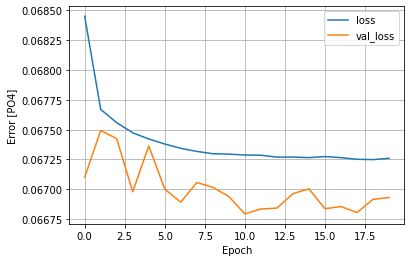

In [87]:
plot_loss(history)

If you plot the predictions as a function of `temp`, you'll see how this model takes advantage of the nonlinearity provided by the hidden layers:

In [88]:
x = tf.linspace(5.0, 30, 251)
y = dnn_temp_model.predict(x)

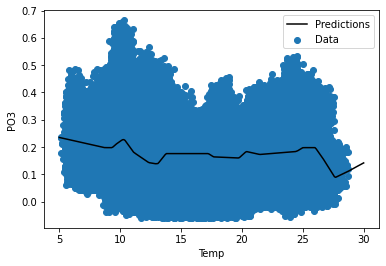

In [89]:
plot_temp(x, y)

Collect the results on the test set, for later:

In [90]:
test_results['dnn_temp_model'] = dnn_temp_model.evaluate(
    test_features['TEMP'], test_target,
    verbose=0)

In [91]:
test_results

{'temp_model': 0.06948475539684296,
 'linear_model': 0.07169545441865921,
 'dnn_temp_model': 0.06726771593093872}

### Full model

If you repeat this process using all the inputs it slightly improves the performance on the validation dataset.

In [92]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 6)                 13        
_________________________________________________________________
dense_6 (Dense)              (None, 64)                448       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,686
Trainable params: 4,673
Non-trainable params: 13
_________________________________________________________________


In [93]:
%%time
history = dnn_model.fit(
    train_features, train_target,
    validation_split=0.1,
    verbose=1, epochs=20)

Epoch 1/20
10969/10969 [==============================] - 11s 974us/step - loss: 0.0466 - val_loss: 0.0382
Epoch 2/20
10969/10969 [==============================] - 11s 978us/step - loss: 0.0385 - val_loss: 0.0371
Epoch 3/20
10969/10969 [==============================] - 11s 963us/step - loss: 0.0371 - val_loss: 0.0363
Epoch 4/20
10969/10969 [==============================] - 11s 963us/step - loss: 0.0366 - val_loss: 0.0377
Epoch 5/20
10969/10969 [==============================] - 10s 956us/step - loss: 0.0363 - val_loss: 0.0361
Epoch 6/20
10969/10969 [==============================] - 11s 967us/step - loss: 0.0359 - val_loss: 0.0360
Epoch 7/20
10969/10969 [==============================] - 11s 969us/step - loss: 0.0357 - val_loss: 0.0355
Epoch 8/20
10969/10969 [==============================] - 11s 975us/step - loss: 0.0355 - val_loss: 0.0352
Epoch 9/20
10969/10969 [==============================] - 11s 1ms/step - loss: 0.0354 - val_loss: 0.0359
Epoch 10/20
10969/10969 [==============

Massively more stable and performant.  Also note that loss is still decreasing at the 20th epoch.  More training may help.

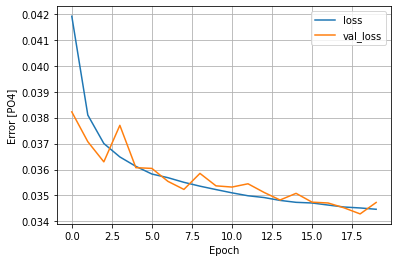

In [94]:
plot_loss(history) 

Collect the results on the test set:

In [95]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_target, verbose=0)

In [96]:
test_results

{'temp_model': 0.06948475539684296,
 'linear_model': 0.07169545441865921,
 'dnn_temp_model': 0.06726771593093872,
 'dnn_model': 0.0347619466483593}

## Performance

Now that all the models are trained check the test-set performance and see how they did:

In [97]:
pd.DataFrame(test_results, index=['Mean absolute error [PO4]']).T

,Mean absolute error [PO4]
temp_model,0.069485
linear_model,0.071695
dnn_temp_model,0.067268
dnn_model,0.034762


These results match the validation error seen during training.

### Make predictions

Finally, predict have a look at the errors made by the model when making predictions on the test set:

In [98]:
test_predictions = dnn_model.predict(test_features).flatten()

In [99]:
test_predictions.shape

(43333,)

In [100]:
test_target['SA PO4'].shape

(43333,)

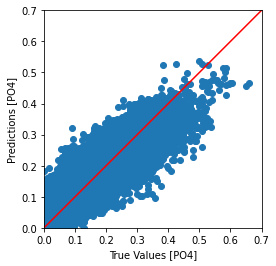

In [101]:
a = plt.axes(aspect='equal')
plt.scatter(test_target['SA PO4'], test_predictions)
plt.xlabel('True Values [PO4]')
plt.ylabel('Predictions [PO4]')
lims = [0, 0.7]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, color='red')

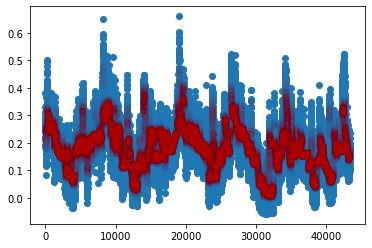

In [102]:
plt.scatter(np.arange(test_target['SA PO4'].shape[0]), test_target['SA PO4'])
plt.scatter(np.arange(test_predictions.shape[0]), test_predictions, color='red', alpha=0.01)

It looks like the model predicts reasonably well. 

Now take a look at the error distribution:

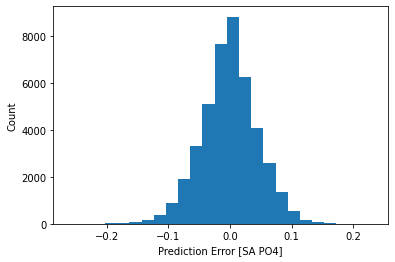

In [103]:
error = test_predictions - test_target['SA PO4']
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [SA PO4]')
_ = plt.ylabel('Count')

If you're happy with the model save it for later use:

In [134]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


In [132]:
dnn_model.save('dnn_model_deltaTsec')

INFO:tensorflow:Assets written to: dnn_model_deltaTsec/assets


If you reload the model, it gives identical output:

In [105]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_target, verbose=0)

In [106]:
pd.DataFrame(test_results, index=['Mean absolute error [PO4]']).T

,Mean absolute error [PO4]
temp_model,0.069485
linear_model,0.071695
dnn_temp_model,0.067268
dnn_model,0.034762
reloaded,0.034762


---

---

###  New section: load validation data and prepare.  Then predict using model.  Plot actual vs predicted for PO4

### Data in validation905.xlsx


---

---

In [107]:
vdata = pd.read_excel("validation905.xlsx",na_values="NaN",  engine='openpyxl')

In [108]:
vdata.head()

,datetime,Year,Time,Month,DAY,Week,GHI,TEMP,PH,EC,TURB,SA DO,SA NO3,SA NH4,SA PO4
0,2021-01-04 19:00:00,2021,19:00:00,1,4,1,2.386,7.3,8.39,679,51,11.7,12.5,0.13,0.16
1,2021-01-04 19:15:00,2021,19:15:00,1,4,1,2.138,7.3,8.38,680,54,11.7,12.5,0.13,0.16
2,2021-01-04 19:30:00,2021,19:30:00,1,4,1,2.026,7.3,8.38,681,56,11.7,12.5,0.13,0.16
3,2021-01-04 19:45:00,2021,19:45:00,1,4,1,2.149,7.3,8.38,681,58,11.7,12.6,0.13,0.16
4,2021-01-04 20:00:00,2021,20:00:00,1,4,1,2.370,7.3,8.38,680,58,11.7,12.5,0.14,0.16


In [109]:
vdata.describe()

,Year,Month,DAY,Week,GHI,TEMP,PH,EC,TURB,SA DO,SA NO3,SA NH4,SA PO4
count,8344.0,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000
mean,2021.0,2.436242,14.659276,2.551414,4.036127,10.884827,8.107258,909.157718,68.657239,10.351498,13.043504,0.170541,0.101683
std,0.0,1.042204,8.267988,1.194294,1.377809,2.790385,0.131936,343.813260,56.250098,1.324320,3.072643,0.103846,0.043062
min,2021.0,1.000000,1.000000,1.000000,2.012000,4.600000,7.670000,510.000000,1.000000,5.200000,0.000000,0.000000,0.000000
25%,2021.0,2.000000,7.000000,1.000000,3.048750,9.500000,8.060000,578.000000,12.000000,9.900000,11.400000,0.100000,0.080000
50%,2021.0,2.000000,15.000000,3.000000,3.666500,10.700000,8.100000,855.000000,60.000000,10.600000,13.100000,0.150000,0.110000
75%,2021.0,3.000000,22.000000,4.000000,5.108250,12.300000,8.160000,1147.000000,109.000000,11.000000,15.200000,0.220000,0.120000
max,2021.0,4.000000,31.000000,5.000000,6.641000,16.900000,8.520000,1719.000000,283.000000,14.000000,18.600000,0.790000,0.270000


In [110]:
vdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8344 entries, 0 to 8343
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  8344 non-null   datetime64[ns]
 1   Year      8344 non-null   int64         
 2   Time      8344 non-null   object        
 3   Month     8344 non-null   int64         
 4   DAY       8344 non-null   int64         
 5   Week      8344 non-null   int64         
 6   GHI       8344 non-null   float64       
 7   TEMP      8344 non-null   float64       
 8   PH        8344 non-null   float64       
 9   EC        8344 non-null   int64         
 10  TURB      8344 non-null   int64         
 11  SA DO     8344 non-null   float64       
 12  SA NO3    8344 non-null   float64       
 13  SA NH4    8344 non-null   float64       
 14  SA PO4    8344 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(6), object(1)
memory usage: 977.9+ KB


No missing data in the validation set.

In [111]:
data.isna().sum()

datetime     0
Year         0
Time         0
Month        0
Day          0
Week         0
GHI          0
TEMP         0
PH           0
EC           0
TURB         0
SA DO        0
SA NO3       0
SA NH4       0
SA PO4       0
deltaTsec    0
dtype: int64

Add the deltaTsec column

In [112]:
vtimes = vdata.datetime

In [113]:
vdeltaT = vtimes - time0

In [114]:
vdeltaTsec = vdeltaT.apply(lambda x: x.total_seconds())

sanity check

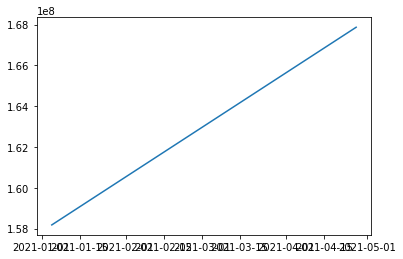

In [118]:
plt.plot(vdata.datetime, vdeltaTsec)

In [116]:
vdata['deltaTsec'] = vdeltaTsec

In [117]:
vdata.head()

,datetime,Year,Time,Month,DAY,Week,GHI,TEMP,PH,EC,TURB,SA DO,SA NO3,SA NH4,SA PO4,deltaTsec
0,2021-01-04 19:00:00,2021,19:00:00,1,4,1,2.386,7.3,8.39,679,51,11.7,12.5,0.13,0.16,158180400.0
1,2021-01-04 19:15:00,2021,19:15:00,1,4,1,2.138,7.3,8.38,680,54,11.7,12.5,0.13,0.16,158181300.0
2,2021-01-04 19:30:00,2021,19:30:00,1,4,1,2.026,7.3,8.38,681,56,11.7,12.5,0.13,0.16,158182200.0
3,2021-01-04 19:45:00,2021,19:45:00,1,4,1,2.149,7.3,8.38,681,58,11.7,12.6,0.13,0.16,158183100.0
4,2021-01-04 20:00:00,2021,20:00:00,1,4,1,2.370,7.3,8.38,680,58,11.7,12.5,0.14,0.16,158184000.0


more sanity check - looking good

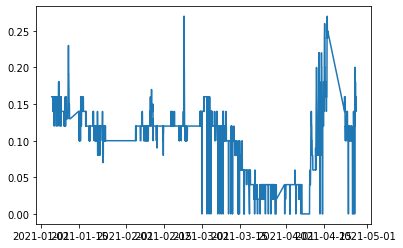

In [119]:
plt.plot(vdata.datetime, vdata['SA PO4'])

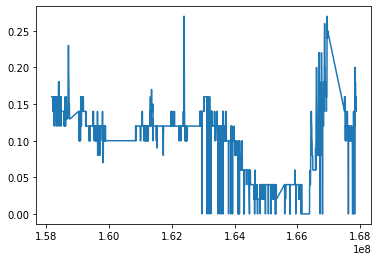

In [120]:
plt.plot(vdata.deltaTsec, vdata['SA PO4'])

In [121]:
vpred = reloaded.predict(vdata[['deltaTsec', 'GHI', 'TEMP', 'PH', 'EC', 'TURB']])

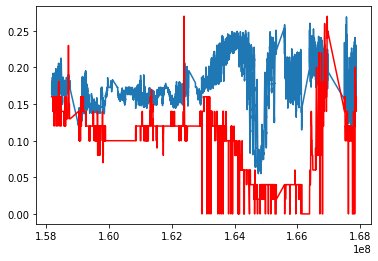

In [131]:
plt.plot(vdata.deltaTsec, vpred)
plt.plot(vdata.deltaTsec, vdata['SA PO4'], color='red')

reloaded.evaluate(test_features, test_target, verbose=1)

In [129]:
reloaded.evaluate(vdata[['deltaTsec', 'GHI', 'TEMP', 'PH', 'EC', 'TURB']], vpred)

261/261 [==============================] - 0s 1ms/step - loss: 0.0000e+00


0.0